In [59]:
import re
import os
import gc
import datetime

import pandas as pd
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors #  implements word vectors
from gensim.test.utils import datapath, get_tmpfile
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.cm as cm

import spacy

from wordcloud import WordCloud

from tqdm.auto import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt

In [2]:

with open('./data/spam.csv', encoding='utf-8', errors='ignore') as f:
    df = pd.read_csv(f)
df.shape

(5572, 5)

In [3]:

df.head(3)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


Variables Unnamed: 2, Unnamed: 3, Unnamed: 4 contain parts of main text of the message in the column v2. Let's concatenate these strings in the column v2, and then drop unnamed columns.

In [5]:

df['v2'] = df.apply(lambda x: ' '.join(filter(None, [x['v2']] + [x[col] for col in ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'] if pd.notna(x[col])])), axis=1)

In [6]:

df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [7]:

df.duplicated().sum()

404

In [8]:

df = df.drop_duplicates().reset_index(drop = True)
df.shape

(5168, 2)

In [9]:

columns = {'v1': 'Category',
          'v2': 'Message'}

df.rename(columns=columns, inplace=True)

In [10]:

df['Category'].value_counts()

Category
ham     4516
spam     652
Name: count, dtype: int64

In [11]:

df['Spam'] = df['Category'].apply(lambda x: 1 if x == "spam" else 0)

df.head()

,Category,Message,Spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


# Text normalization
- replace contractions with full forms of words
- remove stop-words
- remove links, html tags, emails
- convert to lower case, split into individual words
- remove non-letetrs
- -lemmatize text
- -remove extra whitespaces

In [12]:

# Contractions. Source http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [13]:

# Stop-words
stop_words = set(stopwords.words('english')).union({'also', 'would', 'much', 'many'})

negations = {
    'aren',
    "aren't",
    'couldn',
    "couldn't",
    'didn',
    "didn't",
    'doesn',
    "doesn't",
    'don',
    "don't",
    'hadn',
    "hadn't",
    'hasn',
    "hasn't",
    'haven',
    "haven't",
    'isn',
    "isn't",
    'mightn',
    "mightn't",
    'mustn',
    "mustn't",
    'needn',
    "needn't",
    'no',
    'nor',
    'not',
    'shan',
    "shan't",
    'shouldn',
    "shouldn't",
    'wasn',
    "wasn't",
    'weren',
    "weren't",
    'won',
    "won't",
    'wouldn',
    "wouldn't"
}

stop_words = stop_words.difference(negations)

In [15]:

nlp = spacy.load("en_core_web_sm", disable = ['parser','ner'])

def normalize_text(raw_review):
    
    # Remove html tags
    text = re.sub("<[^>]*>", " ", raw_review) # match <> and everything in between. [^>] - match everything except >
    
    # Remove emails
    text = re.sub("\S*@\S*[\s]+", " ", text) # match non-whitespace characters, @ and a whitespaces in the end
    
    # remove links
    text = re.sub("https?:\/\/.*?[\s]+", " ", text) # match http, s - zero or once, //, 
                                                    # any char 0-unlimited, whitespaces in the end
        
     # Convert to lower case, split into individual words
    text = text.lower().split()
    
    # Replace contractions with their full versions
    text = [contractions.get(word) if word in contractions else word 
            for word in text]
   
    # Re-splitting for the correct stop-words extraction
    text = " ".join(text).split()    
    
    # Remove stop words
    text = [word for word in text if not word in stop_words]

    text = " ".join(text)
    
    # Remove non-letters        
    text = re.sub("[^a-zA-Z' ]", "", text) # match everything except letters and '


    # Stem words. Need to define porter stemmer above
    # text = [stemmer.stem(word) for word in text.split()]

    # Lemmatize words. Need to define lemmatizer above
    doc = nlp(text)
    text = " ".join([token.lemma_ for token in doc if len(token.lemma_) > 1 ])
    
    # Remove excesive whitespaces
    text = re.sub("[\s]+", " ", text)    
    
    # Join the words back into one string separated by space, and return the result.
    return(text)

In [16]:

df['text_normalized'] = df['Message'].progress_apply(normalize_text)

  0%|          | 0/5168 [00:00<?, ?it/s]

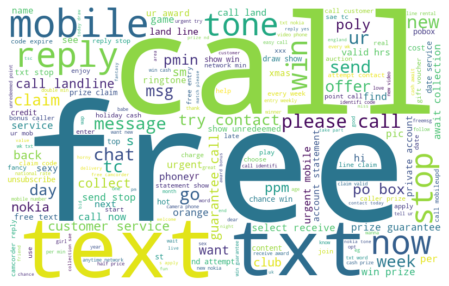

In [17]:

spam_text = ' '.join(df.loc[df['Spam'] == 1, 'text_normalized'])
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(spam_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

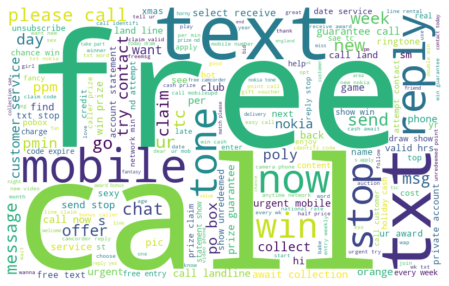

In [18]:

ham_text = ' '.join(df.loc[df['Spam'] == 0, 'text_normalized'])
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(spam_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Observe that words call and free are the most common in both spam and ham sets of messages.

# BOW and TF-IDF

In [24]:

def get_preds(text_column, algorithm, ngrams=(1,1)):
    
    X_train, X_test, y_train, y_test = train_test_split(df[text_column], df.Spam, test_size=0.2, stratify=df['Spam'], random_state=42)
    if algorithm == 'cv':
        vect = CountVectorizer(ngram_range=ngrams).fit(X_train)
    elif algorithm == 'tfidf':
        vect = TfidfVectorizer(ngram_range=ngrams).fit(X_train)
    else:
        raise ValueError('Select correct algorithm: `cv` or `tfidf`')
            
    print('Vocabulary length: ', len(vect.vocabulary_))
    
    # transform the documents in the training data to a document-term matrix

    X_train_vectorized = vect.transform(X_train)
    print('Document-term matrix shape:', X_train_vectorized.shape)
    
    model = LogisticRegression(random_state=42)
    model.fit(X_train_vectorized, y_train)
    
    predictions = model.predict(vect.transform(X_test))
    
    print(f'Used algorithm: {algorithm}')
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('Accuracy: ', accuracy_score(y_test, predictions))
    print('F1-score: ', f1_score(y_test, predictions))


In [25]:
get_preds('text_normalized','tfidf', (1,1))

Vocabulary length:  6432
Document-term matrix shape: (4134, 6432)
Used algorithm: tfidf
AUC:  0.85
Accuracy:  0.9622823984526112
F1-score:  0.8235294117647058


In [26]:

get_preds('text_normalized','cv', (1,1))

Vocabulary length:  6432
Document-term matrix shape: (4134, 6432)
Used algorithm: cv
AUC:  0.9461538461538461
Accuracy:  0.9864603481624759
F1-score:  0.943089430894309


In [27]:

get_preds('Message','cv', (1,1))

Vocabulary length:  7636
Document-term matrix shape: (4134, 7636)
Used algorithm: cv
AUC:  0.9417545949625595
Accuracy:  0.9845261121856866
F1-score:  0.9349593495934959


# Word Embeddings

In [33]:
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for sentence in data:
        word_list = sentence.split(" ")
        corpus.append(word_list)    
           
    return corpus

In [36]:
corpus = build_corpus(df['text_normalized'])
corpus[0]

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'great',
 'world',
 'la',
 'buffet',
 'cine',
 'get',
 'amore',
 'wat']

In [40]:
import os
os.makedirs('./saved_models', exist_ok=True)

In [63]:
# vector_size - Dimensionality of the word vectors
# window - Maximum distance between the current and predicted word within a sentence
# min_count - Ignores all words with total frequency lower than this

model_emb_from_scratch = word2vec.Word2Vec(corpus, vector_size=100, window=7, min_count=100, workers=0)

# saving vectors
model_emb_from_scratch.wv.save_word2vec_format('./saved_models/model_emb_from_scratch.bin', binary=True)

In [28]:

class WordEmbedding: 

    def __init__(self):
        self.model = {}
        
    def convert(self, source, ipnut_file_path, output_file_path):
        '''
        Converts word embeddings from GloVe format to Word2Vec format
        '''
        if source == 'glove':
            glove2word2vec(ipnut_file_path, output_file_path)
        elif source in ['word2vec', 'fasttext', 'from_scratch']:
            pass
        else:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
        
    def load(self, source, file_path):
        '''
        Loads a specified word embedding model from a file
        '''
        print(datetime.datetime.now(), 'start: loading', source)
        if source in ['glove', 'fasttext']:
            self.model[source] = gensim.models.KeyedVectors.load_word2vec_format(file_path)
        elif source in ['word2vec', 'from_scratch']:
            self.model[source] = gensim.models.KeyedVectors.load_word2vec_format(file_path, binary=True)
        else:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        print(datetime.datetime.now(), 'end: loading', source)
            
        return self
    
    def get_model(self, source):
        '''
        Retrieves the loaded word embedding model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        return self.model[source]
    
    def get_words(self, source, size=None):
        '''
        Retrieves a list of words from the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')

        if size is None:
            return [w for w in self.get_model(source=source).key_to_index]
        else:
            results = []
            for i, word in enumerate(self.get_model(source=source).key_to_index):
                if i >= size:
                    break
                results.append(word)
            return results
        
        return Exception('Unexpected flow')
    
    def get_dimension(self, source):
        '''
        Retrieves the dimension of word vectors in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
        
        return self.get_model(source=source).vectors[0].shape[0]
    
    def get_vectors(self, source, words=None):
        '''
        Retrieves vectors for specified words or for all words in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
        
        if words is None:
            words = self.get_words(source=source)
            
        embedding = np.empty((len(words), self.get_dimension(source=source)), dtype=np.float32)
        for i, word in enumerate(words):
            embedding[i] = self.get_vector(source=source, word=word)
                
        return embedding
            
    def get_vector(self, source, word):
        '''
        Retrieves the vector representation of a single word
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)
        
        try:
            return self.model[source][word]
        except KeyError as e:
            dims = self.model[source][0].shape
            vect = np.empty(dims)
            vect[:] = np.nan
            return vect
            
    def get_synonym(self, source, word, topn=5):
        '''
        Retrieves synonyms for a given word
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)
        
        try:
            return self.model[source].most_similar(positive=word, topn=topn)
        except KeyError as e:
            raise
    
    def get_distance_between_two_words(self, source, word1, word2):
        '''
        Calculates cosine similarity between two words in the model
        '''
        if source not in ['glove', 'word2vec', 'fasttext', 'from_scratch']:
            raise ValueError('Possible value of source are glove, word2vec, fasttext, or from_scratch')
            
        if source not in self.model:
            raise ValueError('Did not load %s model yet' % source)
        
        try:
            return self.model[source].similarity(word1, word2)
        except KeyError as e:
            raise
            

In [64]:
word2vec_file_path = './pretrained_models/GoogleNews-vectors-negative300.bin'

fasttext_file_path = './pretrained_models/wiki-news-300d-1M.vec'

from_scratch_file_path = './saved_models/model_emb_from_scratch.bin'

# adding absolute path for correct gensim work
downloaded_glove_file_path = './pretrained_models' + '/glove.6B.50d.txt'
glove_file_path = './pretrained_models' + '/glove.6B.50d.vec'

In [43]:

word_embedding = WordEmbedding()

In [31]:

# We may need to convert text file (downloaed from GloVe website) to vector format
word_embedding.convert(source='glove', ipnut_file_path=downloaded_glove_file_path, output_file_path=glove_file_path)

C:\Users\krist\AppData\Local\Temp\ipykernel_47416\2280601189.py:11: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(ipnut_file_path, output_file_path)


In [44]:

%%time
word_embedding.load(source='word2vec', file_path=word2vec_file_path)
word_embedding.load(source='glove', file_path=glove_file_path)
word_embedding.load(source='fasttext', file_path=fasttext_file_path)
word_embedding.load(source='from_scratch', file_path=from_scratch_file_path)

2024-09-27 19:40:31.771996 start: loading word2vec
2024-09-27 19:40:48.551616 end: loading word2vec
2024-09-27 19:40:48.551616 start: loading glove
2024-09-27 19:40:58.649641 end: loading glove
2024-09-27 19:40:58.649641 start: loading fasttext
2024-09-27 19:43:07.181338 end: loading fasttext
2024-09-27 19:43:07.181338 start: loading from_scratch
2024-09-27 19:43:07.188174 end: loading from_scratch
CPU times: total: 1min 25s
Wall time: 2min 35s


In [45]:

def tok2vec(tokens, source:str, avg:str):
    """
    Given a list of tokens, return their vector representation.
    Args:
        tokens: List(str) tokenized input
        source: embedding algorithm to use with the WordEmbedding object
        avg: vectors averaging method - `sum` or `mean` of all vectors
    """
    vects = word_embedding.get_vectors(source=source, words=tokens)
    expected_vector_size = word_embedding.get_dimension(source=source)
    if len(vects) == 0 or np.all(np.isnan(vects)):
        return np.zeros(expected_vector_size)

    if avg == 'mean':
        return np.nanmean(vects, axis=0)
    elif avg == 'sum':
        return np.nansum(vects, axis=0)
    else:
        raise ValueError('Select correct averaging method: sum or mean')

In [54]:

def get_preds_with_embeddings(df, text_column, source:str, avg='sum'):
    X_train, X_test, y_train, y_test = train_test_split(df[text_column], 
                                                        df.Spam, 
                                                        test_size=0.2, 
                                                        stratify=df['Spam'], random_state=42)
    X_train = X_train.apply(word_tokenize).apply(lambda x: tok2vec(x, source, avg)).to_numpy()
    X_test = X_test.apply(word_tokenize).apply(lambda x: tok2vec(x, source, avg)).to_numpy()
    
    X_train = np.stack(X_train, axis=0)
    X_test = np.stack(X_test, axis=0)
    
    model = LogisticRegression(max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    
    print(f'Used algorithm: {source}')
    print('AUC: ', roc_auc_score(y_test, predictions))
    print('Accuracy: ', accuracy_score(y_test, predictions))
    print('F1-score: ', f1_score(y_test, predictions))
    print(classification_report(y_test, predictions))

In [56]:

get_preds_with_embeddings(df, 'text_normalized', source='word2vec')

Used algorithm: word2vec
AUC:  0.937857385976855
Accuracy:  0.971953578336557
F1-score:  0.8888888888888888
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       904
           1       0.89      0.89      0.89       130

    accuracy                           0.97      1034
   macro avg       0.93      0.94      0.94      1034
weighted avg       0.97      0.97      0.97      1034



In [65]:
get_preds_with_embeddings(df, 'text_normalized', source='from_scratch')

Used algorithm: from_scratch
AUC:  0.5115384615384615
Accuracy:  0.8771760154738878
F1-score:  0.045112781954887216
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       904
           1       1.00      0.02      0.05       130

    accuracy                           0.88      1034
   macro avg       0.94      0.51      0.49      1034
weighted avg       0.89      0.88      0.82      1034



In [60]:
get_preds_with_embeddings(df, 'text_normalized', source='glove')

Used algorithm: glove
AUC:  0.9048757658270933
Accuracy:  0.960348162475822
F1-score:  0.8404669260700389
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       904
           1       0.85      0.83      0.84       130

    accuracy                           0.96      1034
   macro avg       0.91      0.90      0.91      1034
weighted avg       0.96      0.96      0.96      1034



In [61]:

get_preds_with_embeddings(df, 'text_normalized', source='fasttext')

Used algorithm: fasttext
AUC:  0.9450221238938052
Accuracy:  0.9787234042553191
F1-score:  0.9140625
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.93      0.90      0.91       130

    accuracy                           0.98      1034
   macro avg       0.96      0.95      0.95      1034
weighted avg       0.98      0.98      0.98      1034



In [62]:

get_preds_with_embeddings(df, 'Message', source='fasttext')
    

Used algorithm: fasttext
AUC:  0.9538206262763784
Accuracy:  0.9825918762088974
F1-score:  0.9296875
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       904
           1       0.94      0.92      0.93       130

    accuracy                           0.98      1034
   macro avg       0.97      0.95      0.96      1034
weighted avg       0.98      0.98      0.98      1034




## Conclusions
All models, except for the embedding model trained from scratch, proved to be effective and demonstrated sufficient variability in the data. The logistic regression models trained on the corresponding vector representations of email messages effectively classified the messages as spam or ham in the validation set. The best metrics were achieved by the model trained on vectors obtained using Bag of Words (BoW) without applying ngrams and on unprocessed text. This suggests that analyzing word sequences does not provide additional information that would be useful for classification. Additionally, when preparing the text (removing stop words, etc.), we lose some information, which slightly worsens the metrics.

The models trained on vectors obtained using pretrained embedding models also showed good accuracy. The best metrics were achieved with vectors obtained using FastText. Unfortunately, the embedding model built from scratch does not generate meaningful features. The logistic regression model trained on vectors obtained using the from-scratch model classifies almost all messages as ham and is able to recognize only 2% of spam messages. Although we observe a decent accuracy score of 0.87, this is due to the class imbalance. The AUC, however, is only 0.51, which almost indicates random guessing, and the more detailed classification report clearly shows the reasons for such figures. Therefore, multiple metrics, rather than just accuracy, were used to evaluate model quality, as accuracy does not reflect the true performance of a model in the case of imbalanced data.

## Висновки
 Всі моделі,окрім моделі ембедінгів from scratch, виявились ефективними та відобразили достатню варітативність даних так, що навчені на відповідних векторних відображеннях email повідомлень моделі логістичної регресії ефективно класифікували повідомлення як спам та легітимні повідомлення у валідаційному наборі. Найкращі метрики показала модель, натренована на векторах, отриманих за допомогою BoW, без застосування ngrams та на необроблеому тексті. Це свідчить про те, що аналіз послідовностей слів не додає додаткової інформації, що може бути корисна для класифікації. Крім того, при підготовці тексу (видаленні стоп-слів і т.д.) ми втрачаємо частину інформації, що дещо погіршує метрики.

Моделі навчені на векторах, отриманих за допомогою натренованих моделкй ембедінгів, також виявилися досить точними. Найкращі метрики дали вектори, отримані за допомогою fasttext.
На жаль, модель ембедінгів, побудована from scratch, не створює значущі ознаки. Модель логістичної регресії, що натренована на внкторах, отриманих за допомогою моделі from scratch, класифікує майже всі повідомлення як ham, і здатна розпізнати лише 2% спам повідомлень. Хоча ми бачимо непоганий accuracу score 0.87, що викликано незбалансованістю класів, натомість AUC лише 0.51, що майже означає випадкове вгадування, а з більш детального classification report ясно видно причини отримання таких цифр. Саме тому для оцінки якості моделей застосовано одразу декілька метрик, отрім accuracу, адже в незбалансованих даних вона не відоьражає дійсну якість моделі.
